In [34]:
# -----------------------
# Cell 1: Imports & setup
# -----------------------
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Create output folder for charts/CSVs
os.makedirs("analysis_outputs", exist_ok=True)

print("Ready. Output directory: ./analysis_outputs")

hyro_path = "/Users/teitelbaumsair/Desktop/Open-Source-Projects/Hyro Content Evaluation July 2025.csv"
utter_path = "/Users/teitelbaumsair/Desktop/Open-Source-Projects/utterance_with_flags_sample.csv"

def safe_read_csv(path):
    # Try a few common encodings (simple robust loader)
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    # If all fail, raise the last error
    return pd.read_csv(path)  # try default and let it raise if error

hyro = safe_read_csv(hyro_path)
utter = safe_read_csv(utter_path)

print("Hyro shape:", hyro.shape)
print("Utterance shape:", utter.shape)
print("Sample columns (Hyro):", hyro.columns.tolist()[:20])
print("Sample columns (Utter):", utter.columns.tolist()[:20])

Ready. Output directory: ./analysis_outputs
Hyro shape: (100, 8)
Utterance shape: (100, 16)
Sample columns (Hyro): ['CONVERSATION_ID', 'Conversation Dialogue', 'Primary Issue Category', 'Primary Failure Signal', 'Secondary Issue Category', 'Secondary Failure Signal', 'Criticality', 'Notes']
Sample columns (Utter): ['CONVERSATION_ID', 'turn_index', 'speaker', 'utterance_raw', 'utterance', 'char_count', 'word_count', 'utterance_lc', 'didnt_catch', 'say_it_again', 'please_hold', 'transfer_to_agent', 'verify_details', 'ask_zip', 'ask_dob', 'menu_options']


In [35]:
# -------------------------------
# Clean utterances
# -------------------------------
def clean_text(s):
    if pd.isna(s):
        return ""
    s = str(s)
    # remove urls/emails/extra whitespace
    s = re.sub(r"http\S+|www\.\S+|\S+@\S+", " ", s)
    s = re.sub(r"\s+", " ", s)
    s = s.strip()
    return s.lower()

merged['utterance_text_clean'] = merged['utterance_text'].astype(str).apply(clean_text)

# -------------------------------
# Normalize speaker
# -------------------------------
if 'speaker' in merged.columns:
    merged['speaker_norm'] = merged['speaker'].astype(str).str.lower()
else:
    merged['speaker_norm'] = merged['author'].astype(str).str.lower() if 'author' in merged.columns else ""

# Heuristic agent detection
agent_keywords = ['agent','bot','assistant','system','ai','hyro']
merged['is_agent'] = merged['speaker_norm'].apply(lambda s: any(k in s for k in agent_keywords))

# -------------------------------
# Detect and rename label columns (primary + secondary)
# -------------------------------
possible_primary_issue   = [c for c in hyro.columns if 'primary' in c and 'issue' in c]
possible_secondary_issue = [c for c in hyro.columns if 'secondary' in c and 'issue' in c]
possible_primary_fail    = [c for c in hyro.columns if 'primary' in c and 'failure' in c]
possible_secondary_fail  = [c for c in hyro.columns if 'secondary' in c and 'failure' in c]

primary_issue_col   = possible_primary_issue[0]   if possible_primary_issue   else None
secondary_issue_col = possible_secondary_issue[0] if possible_secondary_issue else None
primary_fail_col    = possible_primary_fail[0]    if possible_primary_fail    else None
secondary_fail_col  = possible_secondary_fail[0]  if possible_secondary_fail  else None

# Rename consistently
rename_map = {}
if primary_issue_col:   rename_map[primary_issue_col]   = 'primary_issue'
if secondary_issue_col: rename_map[secondary_issue_col] = 'secondary_issue'
if primary_fail_col:    rename_map[primary_fail_col]    = 'primary_failure_signal'
if secondary_fail_col:  rename_map[secondary_fail_col]  = 'secondary_failure_signal'

merged = merged.rename(columns=rename_map)

# -------------------------------
# Flag rows with *any* failure labeling
# -------------------------------
label_cols = ['primary_issue','secondary_issue','primary_failure_signal','secondary_failure_signal','criticality']
existing_label_cols = [c for c in label_cols if c in merged.columns]
merged['is_failure_labeled'] = merged[existing_label_cols].notna().any(axis=1)

# -------------------------------
# Create a compact text version
# -------------------------------
def remove_structural_tokens(s):
    return re.sub(r"\b(bot|user|entity|agent)\b", " ", s)

merged['utterance_slim'] = (
    merged['utterance_text_clean']
    .astype(str)
    .apply(remove_structural_tokens)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# -------------------------------
# Quick sanity checks
# -------------------------------
print("Unique speaker examples:", merged['speaker_norm'].unique()[:10])
print("Total agent utterances:", merged['is_agent'].sum())
print("Unique convos with failure labels:", merged.loc[merged['is_failure_labeled'], 'conversation_id'].nunique())

# Show sample of label columns
print(merged[['conversation_id','primary_issue','secondary_issue','primary_failure_signal','secondary_failure_signal','criticality']].head())


Unique speaker examples: ['bot' 'user']
Total agent utterances: 98
Unique convos with failure labels: 100
                        conversation_id                  primary_issue  \
0  f50efaec-2a71-4856-955d-0b7e569765f6   Conversation-Level Red Flags   
1  cc89ccfc-7bef-428c-8256-dcca4fddfa59   Conversation-Level Red Flags   
2  086b53be-f7c4-41ab-8925-7d99d2916e85  Software / Technical Failures   
3  7a069e20-cce4-4287-9ee8-2f26d1343b61   NLU (Understanding) Failures   
4  e5a53d3c-871e-4afc-9604-4cad0ce3cc3c  Software / Technical Failures   

                secondary_issue secondary_issue  \
0  Conversation-Level Red Flags            <NA>   
1                           NaN            <NA>   
2  Conversation-Level Red Flags            <NA>   
3  Conversation-Level Red Flags            <NA>   
4  Conversation-Level Red Flags            <NA>   

                 primary_failure_signal secondary_failure_signal  \
0  Conversation ends without resolution                     <NA>   
1  Con

In [36]:
# Focus on agent utterances in conversations that have been labeled as failures
agent_failures = merged[(merged['is_agent']) & (merged['is_failure_labeled'])].copy()
print("Agent utterances inside labeled-failures:", agent_failures.shape[0])

# Get top n-grams (1..4) by raw frequency
def get_top_ngrams(corpus, n=40, ngram_range=(1,4), min_df=1):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', min_df=min_df)
    X = vec.fit_transform(corpus)
    sums = np.array(X.sum(axis=0)).flatten()
    idx = np.argsort(sums)[::-1]
    features = np.array(vec.get_feature_names_out())[idx]
    counts = sums[idx]
    return list(zip(features[:n], counts[:n]))

# compute, but first ensure we remove structural tokens that are dataset artifacts
agent_failures['utterance_slim'] = agent_failures['utterance_slim'].astype(str)
top_ngrams = get_top_ngrams(agent_failures['utterance_slim'], n=40, ngram_range=(1,4), min_df=1)

# Save & show top ngrams
pd.DataFrame(top_ngrams, columns=['ngram','count']).to_csv("analysis_outputs/top_ngrams_agent_fail_cleaned.csv", index=False)
print("Top n-grams (sample):")
for g,c in top_ngrams[:25]:
    print(f"{g} — {c}")


Agent utterances inside labeled-failures: 98
Top n-grams (sample):
appointment — 723
schedule — 494
like — 339
patient — 246
schedule appointment — 222
looking — 214
provider — 197
help — 196
spanish — 196
hold — 188
appointment schedule — 188
details — 183
looking schedule — 164
thank — 159
looking schedule appointment — 137
verify — 137
verify details — 136
calling — 125
code — 119
enter — 114
yes — 114
say — 113
sure — 112
correct — 111
sounds like — 110


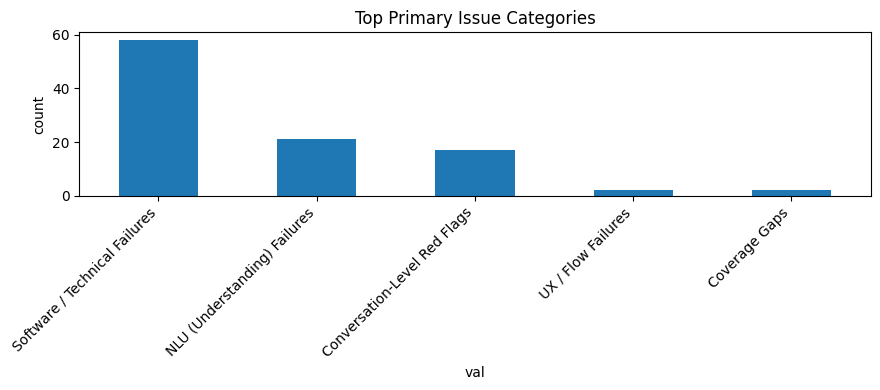

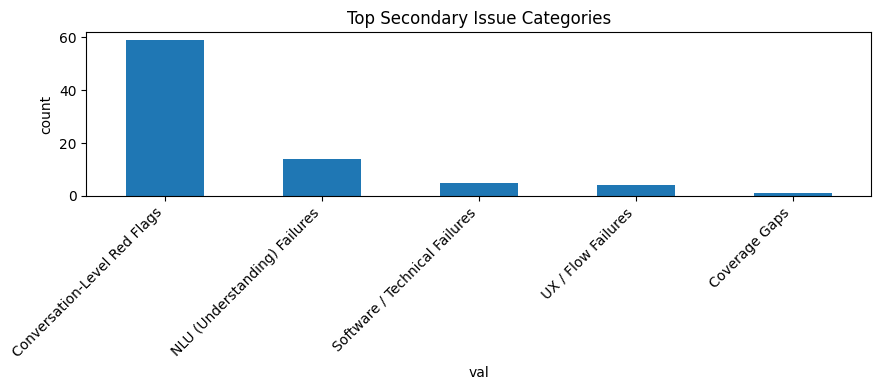

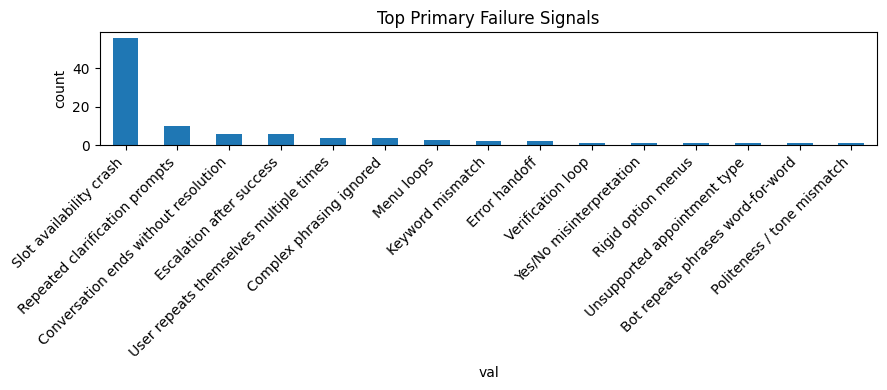

[info] No data for: Top Secondary Failure Signals


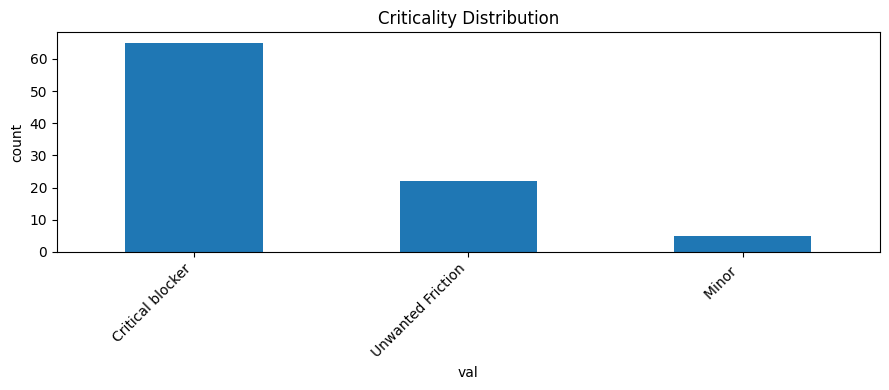

In [37]:
# -------------------------------
# Helper: safely get a single Series even if duplicate columns exist
# -------------------------------
def get_series(df, name):
    """
    Returns a single pandas Series for the given column 'name'.
    Handles cases where duplicate columns exist (returns the first match).
    Returns (series, actual_column_name) or (None, None) if not found.
    """
    # exact matches first, then suffix matches (e.g., after merges)
    candidates = [c for c in df.columns if c == name]
    if not candidates:
        # optionally look for variants created by merges
        candidates = [c for c in df.columns if c.endswith(f"_{name}")]

    if not candidates:
        return None, None

    colname = candidates[0]
    s = df[colname]
    # If duplicates still produced a DataFrame, take first column
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]
    return s, colname

# Get single-Series views for each label column
pri_issue_s,  pri_issue_name  = get_series(merged, 'primary_issue')
sec_issue_s,  sec_issue_name  = get_series(merged, 'secondary_issue')
pri_fail_s,   pri_fail_name   = get_series(merged, 'primary_failure_signal')
sec_fail_s,   sec_fail_name   = get_series(merged, 'secondary_failure_signal')
critical_s,   critical_name   = get_series(merged, 'criticality')

# Convenience: small helper to count per conversation_id
def counts_per_conversation(series, title_for_debug=None, only_non_null=False):
    if series is None:
        return pd.Series(dtype=int)
    df_tmp = merged[['conversation_id']].copy()
    df_tmp['val'] = series
    if only_non_null:
        df_tmp = df_tmp[df_tmp['val'].notna()]
    df_tmp = df_tmp.drop_duplicates('conversation_id')
    return df_tmp['val'].value_counts(dropna=True)

# -------------------------------
# Build the series for plotting
# -------------------------------
# Primary Issue
primary_counts = counts_per_conversation(pri_issue_s)

# Secondary Issue (only conversations where secondary issue exists)
secondary_counts = counts_per_conversation(sec_issue_s, only_non_null=True)

# Primary Failure Signal
failure_counts = counts_per_conversation(pri_fail_s)

# Secondary Failure Signal (only conversations where secondary failure exists)
secondary_failure_counts = counts_per_conversation(sec_fail_s, only_non_null=True)

# Criticality
criticality_counts = counts_per_conversation(critical_s)

# -------------------------------
# Plot helper
# -------------------------------
def bar_from_series(s, title, fname):
    if s is None or s.empty:
        print(f"[info] No data for: {title}")
        return
    plt.figure(figsize=(9,4))
    s_plot = s.sort_values(ascending=False).head(15)
    s_plot.plot.bar()
    plt.title(title)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

# -------------------------------
# Generate plots
# -------------------------------
bar_from_series(primary_counts,           "Top Primary Issue Categories",         "analysis_outputs/primary_issue_counts.png")
bar_from_series(secondary_counts,         "Top Secondary Issue Categories",       "analysis_outputs/secondary_issue_counts.png")
bar_from_series(failure_counts,           "Top Primary Failure Signals",          "analysis_outputs/primary_failure_counts.png")
bar_from_series(secondary_failure_counts, "Top Secondary Failure Signals",        "analysis_outputs/secondary_failure_counts.png")
bar_from_series(criticality_counts,       "Criticality Distribution",             "analysis_outputs/criticality_counts.png")

In [41]:
# ===============================
# CLUSTERING + EXPORTS FOR TABLEAU
# ===============================
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

# ---- Config ----
FORCE_K = 6        # set to an int (e.g., 6) to force k, or set to None to auto-pick by silhouette
MAX_FEATURES = 3000  # TF-IDF vocab size
NGRAM_RANGE = (1, 3) # unigrams to trigrams

# 0) Safety checks
if 'utterance_slim' not in merged.columns:
    raise ValueError("expected merged['utterance_slim'] to exist. Please run cleaning cells first.")

# Focus on agent utterances inside labeled failures (same filter as before)
agent_failures = merged[(merged.get('is_agent', False)) & (merged.get('is_failure_labeled', False))].copy()

if agent_failures.empty:
    print("[info] No agent failure utterances found. Skipping clustering.")
else:
    # 1) Vectorize with TF-IDF
    texts = agent_failures['utterance_slim'].fillna("").astype(str).tolist()
    tfidf = TfidfVectorizer(ngram_range=NGRAM_RANGE, stop_words='english', max_features=MAX_FEATURES)
    X = tfidf.fit_transform(texts)

    # 2) Choose k (silhouette) unless forced
    if FORCE_K is not None:
        best_k = int(FORCE_K)
        print(f"[info] Using forced k={best_k}")
    else:
        sil_scores = {}
        # reasonable range; guard upper bound
        max_k_try = min(10, max(3, X.shape[0] - 1))
        for k in range(2, max_k_try + 1):
            km_try = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels_try = km_try.fit_predict(X)
            try:
                sil_scores[k] = silhouette_score(X, labels_try)
            except Exception:
                sil_scores[k] = np.nan
        print("Silhouette scores:", sil_scores)
        valid = {k: v for k, v in sil_scores.items() if not np.isnan(v)}
        best_k = max(valid, key=lambda k: valid[k]) if valid else 3
        print(f"[info] Chosen k: {best_k}")

    # 3) Final KMeans
    km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    agent_failures['cluster'] = km.fit_predict(X)

    # 4) Top terms per cluster
    terms = np.array(tfidf.get_feature_names_out())
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    cluster_top_terms = {i: terms[order_centroids[i, :20]].tolist() for i in range(best_k)}

    for i in range(best_k):
        print(f"Cluster {i} top terms:", cluster_top_terms[i][:10])

    # 5) Map cluster -> human-readable theme (simple heuristic; adjust as needed)
    def infer_theme(top_terms):
        t = set(top_terms)
        # Verification / Identity
        if {'phone','number','verify','code','dob','zip','read'} & t:
            return "Verification / Identity Capture Failures"
        # Time slot / availability
        if {'time','slots','available','availability','morning','afternoon'} & t or \
           any(kw in top_terms for kw in ['time slots','available time','availability','11 00']):
            return "Time Slot / Availability Failures"
        # New appointment scheduling
        if 'new' in t or 'new appointment' in t or 'schedule new' in t:
            return "Scheduling New Appointments"
        # NLU / description mismatch
        if {'description','scheduling','match','type','seen'} & t or \
           any('description' in kw for kw in top_terms):
            return "NLU / Description Mismatch"
        # General scheduling / provider / language routing
        if {'appointment','schedule','provider','spanish','help','patient'} & t:
            return "Scheduling Loops / Language Routing"
        # Fallback
        return "Other / Miscellaneous"

    cluster_theme_map = {i: infer_theme(cluster_top_terms[i]) for i in range(best_k)}
    agent_failures['cluster_theme'] = agent_failures['cluster'].map(cluster_theme_map)

    # 6) Representative utterance per cluster (closest to centroid)
    representatives = []
    centroids = km.cluster_centers_
    for i in range(best_k):
        members_idx = np.where(agent_failures['cluster'] == i)[0]
        if len(members_idx) == 0:
            continue
        dists = euclidean_distances(X[members_idx].toarray(), centroids[i].reshape(1, -1)).flatten()
        nearest = members_idx[np.argmin(dists)]
        row = agent_failures.iloc[nearest]
        representatives.append({
            "cluster": i,
            "cluster_theme": cluster_theme_map[i],
            "representative": row.get('utterance_slim', ""),
            "conversation_id": row.get('conversation_id', ""),
            "turn_index": row.get('turn_index', np.nan),
            "top_terms": ", ".join(cluster_top_terms[i][:10])
        })

    # 7) SAVE: row-level cluster assignments
    out1_cols = [
        "conversation_id", "turn_index", "speaker", "is_agent",
        "utterance_text", "utterance_text_clean", "utterance_slim",
        "primary_issue", "secondary_issue", "primary_failure_signal", "secondary_failure_signal", "criticality",
        "cluster", "cluster_theme"
    ]
    for c in out1_cols:
        if c not in agent_failures.columns:
            agent_failures[c] = pd.NA
    agent_failures[out1_cols].to_csv("analysis_outputs/agent_failures_with_clusters.csv", index=False)
    print("[saved] analysis_outputs/agent_failures_with_clusters.csv")

    # 8) SAVE: one row per cluster (representatives)
    pd.DataFrame(representatives).to_csv("analysis_outputs/cluster_representatives.csv", index=False)
    print("[saved] analysis_outputs/cluster_representatives.csv")

    # 9) OPTIONAL: add cluster fields back to the full merged dataset and save for Tableau
    #    (Rows without a cluster will have NaN for cluster and cluster_theme)
    merged = merged.merge(
        agent_failures[["conversation_id", "turn_index", "cluster", "cluster_theme"]],
        how="left",
        on=["conversation_id", "turn_index"]
    )

    out_all_cols = [
        "conversation_id","turn_index","speaker","is_agent",
        "utterance_text","utterance_text_clean","utterance_slim",
        "primary_issue","secondary_issue","primary_failure_signal","secondary_failure_signal","criticality",
        "cluster","cluster_theme"
    ]
    for c in out_all_cols:
        if c not in merged.columns:
            merged[c] = pd.NA
    merged[out_all_cols].to_csv("analysis_outputs/processed_for_tableau_with_clusters.csv", index=False)
    print("[saved] analysis_outputs/processed_for_tableau_with_clusters.csv")



[info] Using forced k=6
Cluster 0 top terms: ['appointment', 'schedule', 'like', 'new appointment', 'new', 'schedule new appointment', 'schedule new', 'details', 'looking', 'patient']
Cluster 1 top terms: ['number', 'phone', 'appointment', 'patient phone', 'patient', 'schedule', 'read', 'number file patient', 'number file', 'file patient']
Cluster 2 top terms: ['afternoon', 'appointment', 'morning', 'afternoon morning', 'visit', 'schedule', 'office', 'office visit', 'availability', 'physical']
Cluster 3 top terms: ['appointment', 'schedule', 'like', 'schedule appointment', 'appointment schedule', 'looking', 'patient', 'help', 'spanish', 'provider']
Cluster 4 top terms: ['appointment', 'schedule', 'like', 'scheduling', 'description tell', 'seen make sure', 'description', 'scheduling right', 'match description tell', 'seen']
Cluster 5 top terms: ['00', 'time slots', 'slots', '11 00', '11', 'available time', 'works', 'available time slots', 'available', 'morning']
[saved] analysis_outputs

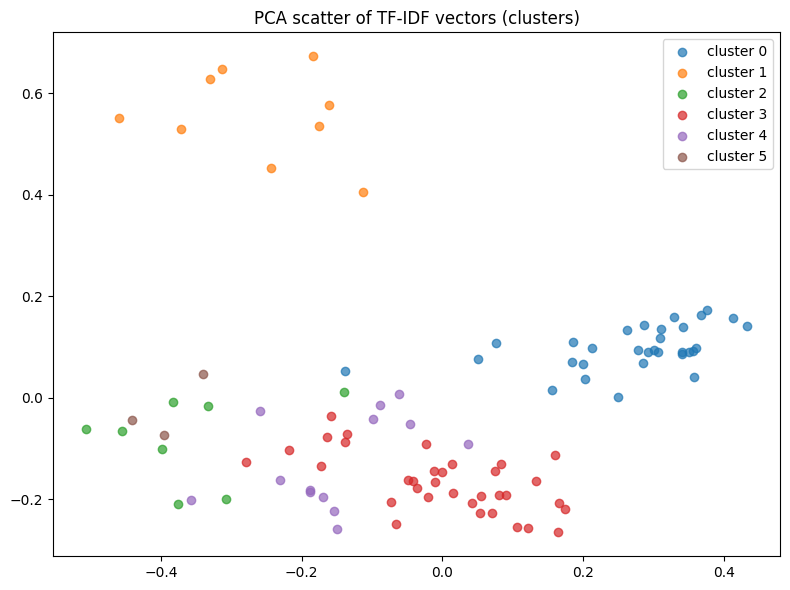

Saved cluster representatives.


In [39]:
from sklearn.metrics.pairwise import euclidean_distances

# PCA for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
for k in sorted(agent_failures['cluster'].unique()):
    idx = agent_failures['cluster'] == k
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f"cluster {k}", alpha=0.7)
plt.legend()
plt.title("PCA scatter of TF-IDF vectors (clusters)")
plt.tight_layout()
plt.savefig("analysis_outputs/cluster_pca.png")
plt.show()

# Representative utterance per cluster (closest to centroid)
centroids = km.cluster_centers_
representatives = []
for i in range(best_k):
    members_idx = np.where(agent_failures['cluster'] == i)[0]
    if len(members_idx) == 0:
        continue
    dists = euclidean_distances(X[members_idx].toarray(), centroids[i].reshape(1, -1)).flatten()
    nearest = members_idx[np.argmin(dists)]
    row = agent_failures.iloc[nearest]
    representatives.append({
        "cluster": i,
        "representative": row['utterance_slim'],
        "conversation_id": row['conversation_id'],
        "turn_index": row.get('turn_index', np.nan),
        "top_terms": cluster_top_terms[i][:10]
    })

pd.DataFrame(representatives).to_csv("analysis_outputs/cluster_representatives.csv", index=False)
print("Saved cluster representatives.")

In [40]:
out_cols = [
    "conversation_id","turn_index","speaker","speaker_norm","is_agent",
    "utterance_text","utterance_text_clean","utterance_slim",
    "primary_issue","secondary_issue","primary_failure_signal","secondary_failure_signal","criticality","cluster"
]
for c in out_cols:
    if c not in merged.columns:
        merged[c] = pd.NA

processed_for_tableau = merged[out_cols].copy()
processed_for_tableau.to_csv("analysis_outputs/processed_for_tableau.csv", index=False)
print("Saved processed CSV for Tableau: analysis_outputs/processed_for_tableau.csv")


Saved processed CSV for Tableau: analysis_outputs/processed_for_tableau.csv
